••••••••••••••••••••••••••••••••••••••••••
dcre_nb_003_data.xlsx
Single-neuron spike frequency (#/min): [ 6.   9.   7.5  6.5 11.5  8.   7.5  6.   7.5  6.5]
Single-neuron spike mean amplitude: [0.717165   1.33442057 1.01436122 0.98366651 1.24773321 0.51406438
 0.84615144 0.7337272  0.75895721 0.70460095]
Fisher Z correlation among active ROIs: 1.35447715489182
Synchronous spike frequency (#/min): 7.5
Synchronous spike mean amplitude: 0.7458245012529007
••••••••••••••••••••••••••••••••••••••••••


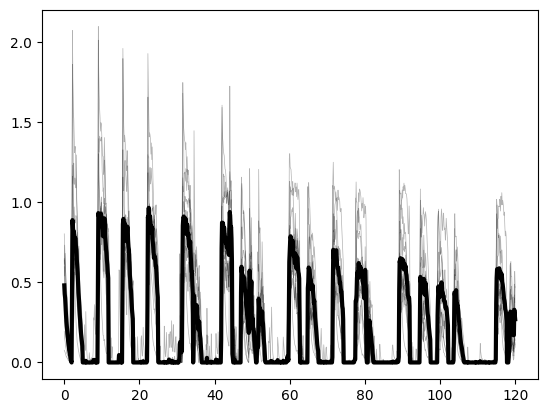

In [8]:
# Use this file to find spikes and correlation in GCaMP videos (upward spiking)

file = 'dcre_nb_003_data.xlsx' ## Must include .xlsx
video_duration = 120 # In seconds

trace_outputs = True # False is default.
# Change to True if you want a file containing normalized values.
# Useful for making an example plot in GraphPad Prism, but not necessary for every file.

# -------------------------------------------------------------------

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

folder = "/content"

np.seterr(divide='ignore')


def findspikes(trace):
    a = trace.mean()
    b = trace.mean() + trace.std()
    amps = []

    below_a = trace[0] < a
    above_b = trace[0] > b
    if above_b:
        spike_end = 0
        while trace[spike_end] > b:
            spike_end += 1
        amps.append(max(trace[0:spike_end]))

    for i in range(len(trace)):
        if trace[i] < a:
            below_a = True
            above_b = False
        elif below_a and (trace[i] > b):
            spike_end = i
            while trace[spike_end] > b:
                spike_end += 1
                if spike_end >= len(trace)-1:
                  break
            amps.append(max(trace[i:spike_end]))

            above_b = True
            below_a = False
    return len(amps), np.array(amps).mean()

data = pd.read_excel(os.path.join(folder, file))
print("••••••••••••••••••••••••••••••••••••••••••")
print(file)

single_neuron_spikes = np.zeros(len(data.columns))
single_neuron_amplitudes = np.zeros(len(data.columns))
normalized_df = data.copy()

for i in range(len(data.columns)):
    trace = data.iloc[:,i]
    rolling_min = trace.rolling(round(len(trace)/(video_duration/3))).min()
    rolling_min[:(round(len(trace)/(video_duration/3))-1)] = rolling_min[round(len(trace)/(video_duration/3))-1]
    flattened = trace-rolling_min+trace.min()
    deltaF_F0 = (flattened-flattened.min())/flattened.min()
    plt.plot(np.linspace(0,video_duration, len(data)), deltaF_F0, color='k', linewidth=0.5, alpha=0.3)
    if trace_outputs:
        normalized_df.iloc[:,i] = deltaF_F0
    single_neuron_spikes[i], single_neuron_amplitudes[i] = findspikes(deltaF_F0)

print("Single-neuron spike frequency (#/min):", single_neuron_spikes/(video_duration/60))
print("Single-neuron spike mean amplitude:", single_neuron_amplitudes)

# Correlation coefficient
fisher_z = np.arctanh(data.iloc[:,single_neuron_spikes!=0].corr("pearson"))
fisher_z.replace([np.inf, -np.inf], np.nan, inplace=True)
mean_fisher = fisher_z.mean().mean()
print("Fisher Z correlation among active ROIs:", mean_fisher)

# Synch spike count
trace = data.mean(axis=1)
rolling_min = trace.rolling(round(len(trace)/(video_duration/3))).min()
rolling_min[:(round(len(trace)/(video_duration/3))-1)] = rolling_min[round(len(trace)/(video_duration/3))-1]
flattened = trace-rolling_min+trace.min()
deltaF_F0 = (flattened-flattened.min())/flattened.min()
plt.plot(np.linspace(0,video_duration, len(data)), deltaF_F0, color='k', linewidth=3)
if trace_outputs:
    normalized_df["Synchronous"] = deltaF_F0

frequency, amplitude = findspikes(deltaF_F0)
print("Synchronous spike frequency (#/min):", frequency/(video_duration/60))
print("Synchronous spike mean amplitude:", amplitude)

if trace_outputs:
    normalized_df.to_excel(folder+'/'+'.'.join(file.split('.')[:-1])+'_normalized.xlsx', index=False)

print("••••••••••••••••••••••••••••••••••••••••••")
# plt.hlines([deltaF_F0.mean(), deltaF_F0.mean()+deltaF_F0.std()],xmin=0,xmax=video_duration)
plt.show()

# New Section

# New Section